In [71]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [72]:
# calculate r-squared
def calculate_r2(y_pred, y_test):
    print("***** R2_score from sklearn.metrics: *****")
    print(r2_score(y_pred, y_test))
    print("y_test variance: ")
    print(y_test.var())
    print("y_test size: ")
    print(y_test.size)
    rse = float(((y_test - y_pred) **2).sum()) / float(y_test.size)
    print("RSE: ")
    print(rse)
    r2 = 1 - float(rse/y_test.var())
    print("***** R2 calculated for test observations: *****")
    print(r2)

In [73]:
def get_test_size():
    return 0.2

In [74]:
def get_random_state():
    return 0

In [75]:
# forward selection to select features
def forward_selection(X, y, max_features=None):
    remaining_features = list(X.columns)
    selected_features = []
    current_best_score = float('inf')

    if max_features is None:
        max_features = len(remaining_features)

    while remaining_features and len(selected_features) < max_features:
        best_feature = None
        for feature in remaining_features:
            temp_features = selected_features + [feature]
            model = LinearRegression()
            model.fit(X[temp_features], y)
            predictions = model.predict(X[temp_features])
            score = mean_squared_error(y, predictions)

            if score < current_best_score:
                current_best_score = score
                best_feature = feature

        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            print(f"Added feature: {best_feature}, Current MSE: {current_best_score}")
            current_best_score = float('inf')
        else:
             break
    return selected_features

In [76]:
# backward selection to select features
def backward_selection(X, y, min_features=1):
    selected_features = list(X.columns)
    current_best_score = float('inf')

    while len(selected_features) > min_features:
        worst_feature = None
        for feature in selected_features:
            temp_features = [f for f in selected_features if f != feature]
            model = LinearRegression()
            model.fit(X[temp_features], y)
            predictions = model.predict(X[temp_features])
            score = mean_squared_error(y, predictions)

            if score < current_best_score:
                current_best_score = score
                worst_feature = feature

        if worst_feature is not None:
            selected_features.remove(worst_feature)
            print(f"Removed feature: {worst_feature}, Current MSE: {current_best_score}")
            current_best_score = float('inf')
        else:
            break
    return selected_features

In [77]:
BHname = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
          'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv("housing.csv", delim_whitespace=True, names = BHname)
df.head()

/tmp/ipython-input-1225195446.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("housing.csv", delim_whitespace=True, names = BHname)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [78]:
# correlation matrix of features
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


## regressor1 = model with all the rows and columns

In [79]:
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
print(y.shape)
print(X.shape)
X = sm.add_constant(X)
print(X.shape)
X.head(2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = get_test_size(), random_state = get_random_state())
regressor1 = sm.OLS(y_train, X_train).fit()
print(regressor1.summary())
y_pred = regressor1.predict(X_test)
calculate_r2(y_pred, y_test)

(506,)
(506, 13)
(506, 14)
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     102.2
Date:                Tue, 19 Aug 2025   Prob (F-statistic):          9.64e-117
Time:                        16:37:19   Log-Likelihood:                -1171.5
No. Observations:                 404   AIC:                             2371.
Df Residuals:                     390   BIC:                             2427.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.0917    

### regressor1 (with all rows and columns) => test r-squared = 59.32%

## Detect Outliers, High Leverage Points and Influence

### Detect Outliers

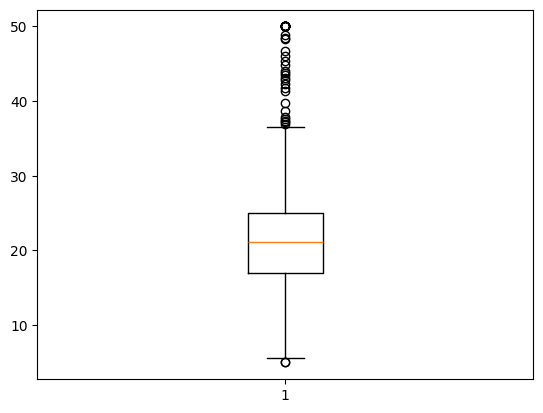

In [80]:
# Outliers detection using boxplot
boxplot = plt.boxplot(df['MEDV'])
plt.show()

In [81]:
outliers = [flier.get_ydata() for flier in boxplot["fliers"]][0]
print(max(outliers))
print(min(outliers))
print(outliers)
print(len(outliers))
outliers_indices = df[df['MEDV'].isin(outliers)].index
print(outliers_indices)

50.0
5.0
[ 5.   5.  38.7 43.8 41.3 50.  50.  50.  50.  37.2 39.8 37.9 50.  37.
 50.  42.3 48.5 50.  44.8 50.  37.6 46.7 41.7 48.3 42.8 44.  50.  43.1
 48.8 50.  43.5 45.4 46.  50.  37.3 50.  50.  50.  50.  50. ]
40
Index([ 97,  98, 157, 161, 162, 163, 166, 179, 180, 182, 186, 190, 195, 202,
       203, 204, 224, 225, 226, 228, 232, 233, 253, 256, 257, 261, 262, 267,
       268, 280, 282, 283, 291, 368, 369, 370, 371, 372, 398, 405],
      dtype='int64')


In [82]:
print(df.shape)
df1 = df[~df['MEDV'].isin(outliers)]
print(df1.shape)
y1 = df1['MEDV']
X1 = df1.loc[:, df1.columns != 'MEDV']
print(y1.shape)
print(X1.shape)
X1 = sm.add_constant(X1)
print(y1.shape)
print(X1.shape)
X1.head(2)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = get_test_size(), random_state = get_random_state())
regressor2 = sm.OLS(y1_train, X1_train).fit()
print(regressor2.summary())
y1_pred = regressor2.predict(X1_test)
calculate_r2(y1_pred, y1_test)

(506, 14)
(466, 14)
(466,)
(466, 13)
(466,)
(466, 14)
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     88.29
Date:                Tue, 19 Aug 2025   Prob (F-statistic):          4.51e-103
Time:                        16:37:19   Log-Likelihood:                -960.11
No. Observations:                 372   AIC:                             1948.
Df Residuals:                     358   BIC:                             2003.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

### regressor2 (removing outliers detected by boxplot) => test r-squared = 74.43%, but 40 rows are removed

In [83]:
# Outliers detection using Z-scores
outliers_zscore = np.abs(regressor1.outlier_test()['bonf(p)']) < 0.05
print(outliers_zscore[outliers_zscore == True])
print(len(outliers_zscore[outliers_zscore == True]))
outliers_indices = outliers_zscore[outliers_zscore == True].index
print(outliers_indices)

368    True
369    True
370    True
Name: bonf(p), dtype: bool
3
Index([368, 369, 370], dtype='int64')


In [84]:
print(df.shape)
df2 = df.drop(index = outliers_indices)
print(df2.shape)
y2 = df2['MEDV']
X2 = df2.loc[:, df2.columns != 'MEDV']
X2 = sm.add_constant(X2)
print(y2.shape)
print(X2.shape)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = get_test_size(), random_state = get_random_state())
regressor3 = sm.OLS(y2_train, X2_train).fit()
print(regressor3.summary())
y2_pred = regressor3.predict(X2_test)
calculate_r2(y2_pred, y2_test)

(506, 14)
(503, 14)
(503,)
(503, 14)
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     97.32
Date:                Tue, 19 Aug 2025   Prob (F-statistic):          2.57e-113
Time:                        16:37:20   Log-Likelihood:                -1168.7
No. Observations:                 402   AIC:                             2365.
Df Residuals:                     388   BIC:                             2421.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         3

### regressor3 (removing outliers detected by Z-scores) => test r-squared = 71.61%, 3 rows are removed

### Check for high leverage points

In [85]:
# High Leverage points check using Leverage statistics (eg. Hat Matrix)
regressor4 = sm.OLS(y, X).fit()
influence = regressor4.get_influence()
leverage = influence.hat_matrix_diag
leverage_points = np.where(leverage > np.mean(leverage) + 2 * np.std(leverage))
print(leverage_points[0])
print(len(leverage_points[0]))

[152 155 214 353 364 365 367 380 405 410 414 418 488 489 490 491 492]
17


In [86]:
print(df.shape)
df3 = df.drop(leverage_points[0], axis = 0)
print(df3.shape)
y3 = df3['MEDV']
X3 = df3.loc[:, df3.columns != 'MEDV']
X3 = sm.add_constant(X3)
print(y3.shape)
print(X3.shape)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = get_test_size(), random_state = get_random_state())
regressor5 = sm.OLS(y3_train, X3_train).fit()
print(regressor5.summary())
y3_pred = regressor5.predict(X3_test)
calculate_r2(y3_pred, y3_test)

(506, 14)
(489, 14)
(489,)
(489, 14)
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     92.52
Date:                Tue, 19 Aug 2025   Prob (F-statistic):          1.42e-108
Time:                        16:37:20   Log-Likelihood:                -1140.5
No. Observations:                 391   AIC:                             2309.
Df Residuals:                     377   BIC:                             2365.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         3

### regressor5 (removing high-leverage-points detected by hat-matrix) => test r-squared = 73.12%, but 17 rows are removed

In [87]:
# High Leverage check using Cook's distance
cook_distance = regressor4.get_influence().cooks_distance[0]
print(4 / df.shape[1])
influential_observations = np.where(cook_distance > 4 / df.shape[1])
print(influential_observations)

0.2857142857142857
(array([], dtype=int64),)


### Detecting High-leverage-points using Cook's distance resulted in no data

### Calculate Influence using DFFITS and DFBETAS

In [88]:
# Influence calculation using DFFITS and DFBETAS
dffits = regressor4.get_influence().dffits[0]
dfbetas = regressor4.get_influence().dfbetas
influential_dffits = np.where(np.abs(dffits) > 2 * np.sqrt(df.shape[1] * regressor4.df_model / regressor4.df_resid))
coefficient_index = 0  # Index of the coefficient to analyze
influential_dfbetas = np.where(np.abs(dfbetas[:, coefficient_index]) > 2 / np.sqrt(df.shape[1]))
print(influential_dffits[0])
print(influential_dfbetas[0])

[368]
[364 367 368]


In [89]:
df4 = df.drop(influential_dffits[0], axis = 0)
print(df4.shape)
y4 = df4['MEDV']
X4 = df4.loc[:, df4.columns != 'MEDV']
X4 = sm.add_constant(X4)
print(y4.shape)
print(X4.shape)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = get_test_size(), random_state = get_random_state())
regressor6 = sm.OLS(y4_train, X4_train).fit()
print(regressor6.summary())
y4_pred = regressor6.predict(X4_test)
calculate_r2(y4_pred, y4_test)

(505, 14)
(505,)
(505, 14)
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     94.81
Date:                Tue, 19 Aug 2025   Prob (F-statistic):          6.21e-112
Time:                        16:37:20   Log-Likelihood:                -1187.7
No. Observations:                 404   AIC:                             2403.
Df Residuals:                     390   BIC:                             2460.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.2921    

### regressor6 (removing influence-points detected by DFFITS) => test r-squared = 69.56%, 1 row is removed

In [90]:
df5 = df.drop(influential_dfbetas[0], axis = 0)
print(df5.shape)
y5 = df5['MEDV']
X5 = df5.loc[:, df5.columns != 'MEDV']
X5 = sm.add_constant(X5)
print(y5.shape)
print(X5.shape)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = get_test_size(), random_state = get_random_state())
regressor7 = sm.OLS(y5_train, X5_train).fit()
print(regressor7.summary())
y5_pred = regressor7.predict(X5_test)
calculate_r2(y5_pred, y5_test)

(503, 14)
(503,)
(503, 14)
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     98.42
Date:                Tue, 19 Aug 2025   Prob (F-statistic):          4.86e-114
Time:                        16:37:20   Log-Likelihood:                -1171.5
No. Observations:                 402   AIC:                             2371.
Df Residuals:                     388   BIC:                             2427.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.8400    

### regressor7 (removing influence-points detected by DFBETAS) => test r-squared = 74.56%, 3 rows are removed

## Checking Multicollinearity using VIF

In [91]:
print(X.columns)
X_vif1 = X.drop('const', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif1.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif1.values, i)
                          for i in range(len(X_vif1.columns))]

print(vif_data)

Index(['const', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
       'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'],
      dtype='object')
    feature        VIF
0      CRIM   2.100373
1        ZN   2.844013
2     INDUS  14.485758
3      CHAS   1.152952
4       NOX  73.894947
5        RM  77.948283
6       AGE  21.386850
7       DIS  14.699652
8       RAD  15.167725
9       TAX  61.227274
10  PTRATIO  85.029547
11        B  20.104943
12    LSTAT  11.102025


In [92]:
X_vif2 = X_vif1.drop('PTRATIO', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif2.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif2.values, i)
                          for i in range(len(X_vif2.columns))]

print(vif_data)

   feature        VIF
0     CRIM   2.099345
1       ZN   2.451624
2    INDUS  14.275283
3     CHAS   1.142167
4      NOX  73.894171
5       RM  60.598846
6      AGE  21.361234
7      DIS  12.221605
8      RAD  15.159162
9      TAX  59.301541
10       B  18.614751
11   LSTAT  10.138324


In [93]:
X_vif3 = X_vif2.drop('NOX', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif3.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif3.values, i)
                          for i in range(len(X_vif3.columns))]

print(vif_data)

   feature        VIF
0     CRIM   2.097537
1       ZN   2.449661
2    INDUS  13.150904
3     CHAS   1.138277
4       RM  41.406746
5      AGE  19.889623
6      DIS  12.032952
7      RAD  15.155012
8      TAX  57.720347
9        B  18.396072
10   LSTAT   9.207840


In [94]:
X_vif4 = X_vif3.drop('TAX', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif4.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif4.values, i)
                          for i in range(len(X_vif4.columns))]

print(vif_data)

  feature        VIF
0    CRIM   2.097466
1      ZN   2.375219
2   INDUS   9.290080
3    CHAS   1.118613
4      RM  39.069063
5     AGE  19.780944
6     DIS  11.817803
7     RAD   4.965633
8       B  18.289917
9   LSTAT   9.046248


In [95]:
X_vif5 = X_vif4.drop('RM', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif5.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif5.values, i)
                          for i in range(len(X_vif5.columns))]

print(vif_data)

  feature        VIF
0    CRIM   2.095367
1      ZN   2.334763
2   INDUS   9.016142
3    CHAS   1.116229
4     AGE  14.000758
5     DIS   8.447694
6     RAD   4.771767
7       B  13.537020
8   LSTAT   8.358925


In [96]:
X_vif6 = X_vif5.drop('B', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif6.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif6.values, i)
                          for i in range(len(X_vif6.columns))]

print(vif_data)

  feature        VIF
0    CRIM   2.072603
1      ZN   2.333806
2   INDUS   8.734978
3    CHAS   1.111181
4     AGE  10.419337
5     DIS   4.353752
6     RAD   4.715170
7   LSTAT   8.263495


In [97]:
X_vif7 = X_vif6.drop('AGE', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif7.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif7.values, i)
                          for i in range(len(X_vif7.columns))]

print(vif_data)

  feature       VIF
0    CRIM  2.067135
1      ZN  2.299351
2   INDUS  6.900077
3    CHAS  1.086574
4     DIS  3.968908
5     RAD  4.678181
6   LSTAT  6.726973


In [98]:
X_vif8 = X_vif7.drop('INDUS', axis = 1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif8.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif8.values, i)
                          for i in range(len(X_vif8.columns))]

print(vif_data)

  feature       VIF
0    CRIM  2.040522
1      ZN  2.237534
2    CHAS  1.059249
3     DIS  3.941629
4     RAD  3.738091
5   LSTAT  4.248513


### 'PTRATIO', 'NOX', 'TAX', 'RM', 'B', 'AGE', 'INDUS' has VIF values much larger than 5. We will remove these features and rebuild our model

In [99]:
y6 = df['MEDV']
X6 = df.drop(columns = ['PTRATIO', 'NOX', 'TAX', 'RM', 'B', 'AGE', 'INDUS'])
print(y6.shape)
print(X6.shape)
X6 = sm.add_constant(X6)
print(X6.shape)
print(X6.head(2))
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size = get_test_size(), random_state = get_random_state())
regressor8 = sm.OLS(y6_train, X6_train).fit()
print(regressor8.summary())
y6_pred = regressor8.predict(X6_test)
calculate_r2(y6_pred, y6_test)

(506,)
(506, 7)
(506, 8)
   const     CRIM    ZN  CHAS     DIS  RAD  LSTAT  MEDV
0    1.0  0.00632  18.0     0  4.0900    1   4.98  24.0
1    1.0  0.02731   0.0     0  4.9671    2   9.14  21.6
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.831e+31
Date:                Tue, 19 Aug 2025   Prob (F-statistic):               0.00
Time:                        16:37:21   Log-Likelihood:                 12343.
No. Observations:                 404   AIC:                        -2.467e+04
Df Residuals:                     396   BIC:                        -2.464e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 

In [100]:
y_fs = df['MEDV']
X_fs = df.loc[: , df.columns != 'MEDV']
print(y_fs.shape)
print(X_fs.shape)
X_fs_train, X_fs_test, y_fs_train, y_fs_test = train_test_split(X_fs, y_fs, test_size = get_test_size(), random_state = get_random_state())
forward_selection_results = forward_selection(X_fs_train, y_fs_train)
print(forward_selection_results)

(506,)
(506, 13)
Added feature: LSTAT, Current MSE: 36.52396640695966
Added feature: RM, Current MSE: 28.79027648205344
Added feature: PTRATIO, Current MSE: 23.681938393213372
Added feature: B, Current MSE: 22.967404602975606
Added feature: DIS, Current MSE: 22.341237458588477
Added feature: NOX, Current MSE: 21.101669447323548
Added feature: CHAS, Current MSE: 20.642625089895443
Added feature: ZN, Current MSE: 20.332689244158495
Added feature: CRIM, Current MSE: 20.010553714989022
Added feature: RAD, Current MSE: 19.81571651195487
Added feature: TAX, Current MSE: 19.32923023783989
Added feature: AGE, Current MSE: 19.326841076541545
Added feature: INDUS, Current MSE: 19.326470203585725
['LSTAT', 'RM', 'PTRATIO', 'B', 'DIS', 'NOX', 'CHAS', 'ZN', 'CRIM', 'RAD', 'TAX', 'AGE', 'INDUS']


In [101]:
y7 = df['MEDV']
X7 = df.drop(columns = ['ZN', 'CRIM', 'RAD', 'TAX', 'AGE', 'INDUS'])
print(y7.shape)
print(X7.shape)
X7 = sm.add_constant(X7)
print(X7.shape)
print(X7.head(2))
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size = get_test_size(), random_state = get_random_state())
regressor9 = sm.OLS(y7_train, X7_train).fit()
print(regressor9.summary())
y7_pred = regressor9.predict(X7_test)
calculate_r2(y7_pred, y7_test)

(506,)
(506, 8)
(506, 9)
   const  CHAS    NOX     RM     DIS  PTRATIO      B  LSTAT  MEDV
0    1.0     0  0.538  6.575  4.0900     15.3  396.9   4.98  24.0
1    1.0     0  0.469  6.421  4.9671     17.8  396.9   9.14  21.6
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.110e+28
Date:                Tue, 19 Aug 2025   Prob (F-statistic):               0.00
Time:                        16:37:21   Log-Likelihood:                 11211.
No. Observations:                 404   AIC:                        -2.240e+04
Df Residuals:                     395   BIC:                        -2.237e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                             

In [102]:
y_bs = df['MEDV']
X_bs = df.loc[: , df.columns != 'MEDV']
print(y_bs.shape)
print(X_bs.shape)
X_bs_train, X_bs_test, y_bs_train, y_bs_test = train_test_split(X_bs, y_bs, test_size = get_test_size(), random_state = get_random_state())
backward_selection_results = backward_selection(X_bs_train, y_bs_train)
print(backward_selection_results)

(506,)
(506, 13)
Removed feature: INDUS, Current MSE: 19.32684107654154
Removed feature: AGE, Current MSE: 19.329230237839894
Removed feature: CHAS, Current MSE: 19.66629515631436
Removed feature: B, Current MSE: 20.10064841502156
Removed feature: ZN, Current MSE: 20.599589614879534
Removed feature: TAX, Current MSE: 21.01084461379949
Removed feature: RAD, Current MSE: 21.181610551690017
Removed feature: CRIM, Current MSE: 21.526048188286254
Removed feature: NOX, Current MSE: 23.137996656850525
Removed feature: DIS, Current MSE: 23.681938393213375
Removed feature: PTRATIO, Current MSE: 28.790276482053443
Removed feature: RM, Current MSE: 36.52396640695966
['LSTAT']
